In [1]:
from itertools import combinations, permutations
from math import factorial

# Static user data for 5 users over 24 hours
# Energy is (injected, withdrawal)
users_data = {
    'user1': { #consumer
        'power': 0,
        'energy': [
            (0, 0,163757327), (0, 0,12998962), (0, 0.133750916), (0, 0.169250488), 
            (0, 0.787757874), (0, 0.151748657),  (0, 0.123001099), (0, 0.115242004), 
            (0, 0.112251282), (0, 0.159248352), (0, 0.200004578), (0, 0.417999268), 
            (0, 1.121253967), (0, 0.621498108), (0, 1.010993958), (0, 1.069755554), 
            (0, 0.966003418), (0, 0.425003052), (0, 0.445243835), (0, 0.945243835), 
            (0, 0.29800415), (0, 0.271751404), (0, 0.28150177), (0, 0.177253723)]
    },
    'user2': { #producer
        'power': 20,
        'energy': [    
            (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0.0624160766595423, 0),(0.98008, 0),
            (2.74285, 0), (3.90898, 0), (4.63280, 0), (4.83644, 0), (5.57781, 0),
            (5.53134, 0), (5.01384, 0), (4.15872, 0), (2.8559, 0), (1.08171, 0), (0.03106, 0),
            (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]        
    },
    'user3': {
        'power': 20,
        'energy': [
            (0, 0.020019531), (0, 0.020019531), (0, 0.023986816), (0, 0.026794434), 
            (0, 0.020507813),(0.004516602, 0.022705078),(0.437774658, 0.020019531),
            (1.286499023, 0.071228027),(2.093048096, 0.345275879),(3.021728516, 0.063232422),
            (3.510742188, 0.076477051),(3.278991699, 0.061584473),(3.74597168, 0.12701416),
            (3.663269043, 0.489929199),(3.09274292, 0.114990234),(2.073242188, 0.082275391),
            (0.718017578, 0.051269531),(0.10446167, 0.047180176),(0, 0.033508301),
            (0, 0.020019531),(0, 0.022766113),(0, 0.021240234),(0, 0.019958496),
            (0, 0.020019531)]
    },
    'user4': {
        'power': 20,
        'energy': [
            (0, 0.020507813), (0, 0.020507813), (0, 0.022766113), (0, 0.026245117), (0, 0.020996094),
            (0.012298584, 0.019958496), (0.182525635, 0.020019531), (0.397186279, 0.108764648),
            (1.448059082, 0.127563477), (2.914001465, 0.066650391), (4.129272461, 0.061035156),
            (4.37322998, 0.049804688), (4.146484375, 0.053955078), (3.868988037, 0.138000488),
            (3.198272705, 0.570556641), (2.315704346, 0.515441895), (1.047790527, 0.493225098),
            (0.140258789, 0.327758789), (0, 0.099731445), (0, 0.042541504), (0, 0.020019531),
            (0, 0.022705078), (0, 0.020263672), (0, 0.020019531)]
    },
    'user5': {
        'power': 25,
        'energy': [
            (0, 0.020019531),(0, 0.020019531), (0, 0.019897461), (0, 0.022033691), (0, 0.023986816), 
            (0.010253906, 0.020019531), (0.365783691, 0.026794434), (1.122955322, 0.057556152), (2.081268311, 0.070678711),
            (3.522521973, 0.101013184), (2.103729248, 0.066467285), (2.151977539, 0.050964355), (2.913269043, 0.104736328),
            (2.413757324, 0.33380127), (2.263214111, 0.197998047), (1.023010254, 0.100708008), (0.25479126, 0.234558105),
            (0.001495361, 0.180236816), (0, 0.028503418), (0, 0.021972656), (0, 0.021057129), (0, 0.020019531), (0, 0.019897461),
            (0, 0.020019531)]

    }
}

energy_price = [0.1]*24 #[200, 190, 180, 200, 190, 180, 200, 190, 180, 200, 190, 180, 200, 190, 180, 200, 190, 180, 200, 190, 180, 200, 190, 180]


# Injection

In [2]:
from itertools import permutations, combinations
from math import factorial

results = {}  # Initialize the results dictionary

def calculate_tip(user_power, energy_injected, energy_price):
    CAP, Base = (0.100, 0.060) if user_power > 600 else (0.110, 0.070) if user_power > 200 else (0.120, 0.080)
    return min(CAP, Base + max(0, 0.180 - energy_price)) * energy_injected

def calculate_shared_energy_and_tips(users_data, energy_price):
    hours = len(users_data[next(iter(users_data))]['energy'])
    shared_energy_hourly = [min(sum(u['energy'][hour][0] for u in users_data.values()),
                                sum(u['energy'][hour][1] for u in users_data.values()))
                            for hour in range(hours)]
    permutation_num = 0

    for order in permutations(users_data.keys()):
        permutation_num += 1
        tips_order_dependent = {user_id: 0 for user_id in users_data}
        shared_energy_by_user = {user_id: [0] * hours for user_id in users_data}
        total_shared_energy, total_tip = 0, 0
        
        for hour in range(hours):
            price = energy_price[hour % len(energy_price)]
            shared_energy_so_far = 0
            
            for user_id in order:
                user = users_data[user_id]
                energy_injected = user['energy'][hour][0]
                remaining_shared_capacity = shared_energy_hourly[hour] - shared_energy_so_far
                energy_counted_for_sharing = min(energy_injected, remaining_shared_capacity)
                shared_energy_so_far += energy_counted_for_sharing
                shared_energy_by_user[user_id][hour] = energy_counted_for_sharing
                tip = calculate_tip(user['power'], energy_counted_for_sharing, price)
                tips_order_dependent[user_id] += tip
                total_tip += tip
            total_shared_energy += shared_energy_so_far
        
        results[permutation_num] = {
            'order': order,
            'users': {user_id: {'shared_energy': shared_energy_by_user[user_id], 'tip': tips_order_dependent[user_id]} for user_id in order},
            'total_shared_energy': total_shared_energy,
            'total_tip': total_tip
        }

    return results

def value_of_coalition(coalition, users_data, energy_price, shared_energy_hourly):
    total_tip = 0
    for hour in range(len(energy_price)):
        total_injected_by_coalition = sum(users_data[user_id]['energy'][hour][0] for user_id in coalition)
        total_withdrawn = sum(users_data[user_id]['energy'][hour][1] for user_id in users_data)
        
        energy_shared = min(total_injected_by_coalition, total_withdrawn)
        
        for user_id in coalition:
            user = users_data[user_id]
            energy_injected = user['energy'][hour][0]
            user_share_proportion = (energy_injected / total_injected_by_coalition) if total_injected_by_coalition > 0 else 0
            energy_shared_by_user = energy_shared * user_share_proportion
            tip = calculate_tip(user['power'], energy_shared_by_user, energy_price[hour])
            total_tip += tip
            
    return total_tip


def print_shared_energy_and_shapley_values_injected(users_data, energy_price):
    results = calculate_shared_energy_and_tips(users_data, energy_price)
    N = len(users_data)
    shapley_values = {user_id: 0 for user_id in users_data}
    hours = len(energy_price)
    shared_energy_hourly = [min(sum(u['energy'][hour][0] for u in users_data.values()),
                                sum(u['energy'][hour][1] for u in users_data.values()))
                            for hour in range(hours)]
    
    for user_id in users_data:
        for S_size in range(N):
            for S in combinations(set(users_data.keys()) - {user_id}, S_size):
                S_with_user = set(S).union({user_id})
                marginal_contribution = value_of_coalition(S_with_user, users_data, energy_price, shared_energy_hourly) - value_of_coalition(S, users_data, energy_price, shared_energy_hourly)
                shapley_values[user_id] += marginal_contribution * factorial(len(S)) * factorial(N - len(S) - 1) / factorial(N)
                
    for perm_num, details in results.items():
        print(f"Permutation {perm_num}: Order: {details['order']}")
        for user_id in details['order']:
            user_details = details['users'][user_id]
            print(f"  {user_id}: Shared Energy: {sum(user_details['shared_energy'])}, TIP: {user_details['tip']}")
        print(f"  Total Shared Energy: {details['total_shared_energy']}, Total TIP: {details['total_tip']}\n")

    print("Shapley Values:")
    for user_id, value in shapley_values.items():
        print(f"  {user_id}: {value} €")
    
    print('Normalized Shapley Values:')
    total = 0
    for user_id, value in shapley_values.items():
        total += value

    for user_id, value in shapley_values.items():
        print(f"  {user_id}: {value/total}")
    
    total_tip = 0
    for perm_num, details in results.items():
        total_tip += details['total_tip']
    print(f'Average TIP: {total_tip / len(results)}')


In [3]:
print_shared_energy_and_shapley_values_injected(users_data, energy_price)

Permutation 1: Order: ('user1', 'user2', 'user3', 'user4', 'user5')
  user1: Shared Energy: 0, TIP: 0.0
  user2: Shared Energy: 10.400970380659542, TIP: 1.248116445679145
  user3: Shared Energy: 0.7723244239999999, TIP: 0.09267893087999998
  user4: Shared Energy: 0.152557373, TIP: 0.01830688476
  user5: Shared Energy: 0.011749266999999973, TIP: 0.0014099120399999967
  Total Shared Energy: 11.337601444659542, Total TIP: 1.3605121733591448

Permutation 2: Order: ('user1', 'user2', 'user3', 'user5', 'user4')
  user1: Shared Energy: 0, TIP: 0.0
  user2: Shared Energy: 10.400970380659542, TIP: 1.248116445679145
  user3: Shared Energy: 0.7723244239999999, TIP: 0.09267893087999998
  user5: Shared Energy: 0.011749267, TIP: 0.00140991204
  user4: Shared Energy: 0.152557373, TIP: 0.01830688476
  Total Shared Energy: 11.337601444659542, Total TIP: 1.3605121733591448

Permutation 3: Order: ('user1', 'user2', 'user4', 'user3', 'user5')
  user1: Shared Energy: 0, TIP: 0.0
  user2: Shared Energy: 10.

# Withdrawal

In [4]:
def value_of_coalition(coalition, users_data, energy_price, results, coalition_key):
    total_shared_withdrawal = 0
    for hour in range(len(energy_price)):
        total_injected = sum(users_data[user_id]['energy'][hour][0] for user_id in users_data)
        total_withdrawn_by_coalition = sum(users_data[user_id]['energy'][hour][1] for user_id in coalition)
        
        energy_shared = min(total_injected, total_withdrawn_by_coalition)
        
        for user_id in coalition:
            user = users_data[user_id]
            energy_withdrawal = user['energy'][hour][1]
            if energy_shared == 0:
                user_share_proportion = 0
            else:
                user_share_proportion = (energy_withdrawal / total_withdrawn_by_coalition) if total_withdrawn_by_coalition <= energy_shared else (energy_withdrawal / energy_shared)
            
            energy_shared_by_user = energy_shared * user_share_proportion
            total_shared_withdrawal += energy_shared_by_user
            
            # Store the shared withdrawal portion for each user, for each hour, under each permutation
            if user_id not in results:
                results[user_id] = {}
            if coalition_key not in results[user_id]:
                results[user_id][coalition_key] = [0]*24  # Initialize with zeros for each hour
            results[user_id][coalition_key][hour] += energy_shared_by_user

    return total_shared_withdrawal

def calculate_shapley_values(users_data, energy_price):
    N = len(users_data)
    shapley_values = {user_id: 0 for user_id in users_data}
    results = {}  # To store detailed results
    
    for user_id in users_data:
        for S_size in range(N):
            for S in combinations(users_data.keys() - {user_id}, S_size):
                S_with_user = S + (user_id,)
                coalition_key_with = '-'.join(sorted(S_with_user))
                coalition_key_without = '-'.join(sorted(S))
                
                value_with_user = value_of_coalition(S_with_user, users_data, energy_price, results, coalition_key_with)
                value_without_user = value_of_coalition(S, users_data, energy_price, results, coalition_key_without)
                
                marginal_contribution = value_with_user - value_without_user
                shapley_values[user_id] += marginal_contribution * factorial(S_size) * factorial(N - S_size - 1) / factorial(N)
                
    return shapley_values, results

shapley_values, detailed_results = calculate_shapley_values(users_data, energy_price)

print("Shapley Values:")
for user_id, value in shapley_values.items():
    print(f"{user_id}: {value:.2f}")

# If you want to see detailed results for a specific user and permutation, you can access it like so:
print(detailed_results['user1'])  # Example access
print(f'Normalized Shapley Values:')
total = 0
for user_id, value in shapley_values.items():
    total += value
for user_id, value in shapley_values.items():
    print(f"{user_id}: {value/total:.2f}")


Shapley Values:
user1: 6.49
user2: 0.00
user3: 1.57
user4: 2.55
user5: 1.55
{'user1': [0, 0, 0, 0, 0, 0.758743285, 0.615005495, 0.57621002, 0.5612564099999999, 0.79624176, 1.0000228899999999, 2.08999634, 5.606269834999999, 3.10749054, 5.05496979, 5.348777770000001, 4.83001709, 2.12501526, 0, 0, 0, 0, 0, 0], 'user1-user4': [0, 0, 0, 0, 0, 0.758743285, 0.615005495, 0.57621002, 0.5612564099999999, 0.79624176, 1.0000228899999999, 2.08999634, 5.606269834999999, 3.10749054, 5.05496979, 5.348777770000001, 4.83001709, 2.12501526, 0, 0, 0, 0, 0, 0], 'user1-user2': [0, 0, 0, 0, 0, 0.758743285, 0.615005495, 0.57621002, 0.5612564099999999, 0.79624176, 1.0000228899999999, 2.08999634, 5.606269834999999, 3.10749054, 5.05496979, 5.348777770000001, 4.83001709, 2.12501526, 0, 0, 0, 0, 0, 0], 'user1-user3': [0, 0, 0, 0, 0, 0.758743285, 0.615005495, 0.57621002, 0.5612564099999999, 0.79624176, 1.0000228899999999, 2.08999634, 5.606269834999999, 3.10749054, 5.05496979, 5.348777770000001, 4.83001709, 2.125015

# Percentage of withdrawal/injection

In [5]:
# Initialize dictionaries to store total withdrawal and injection
total_withdrawal = {}
total_injection = {}

# Calculate total withdrawal and injection
for user, data in users_data.items():
    # Extract energy data for the current user
    energy_data = data['energy']
    
    # Extract injected and withdrawn energy from each tuple
    injected = sum([t[0] for t in energy_data])
    withdrawn = sum([t[1] for t in energy_data])
    
    # Add to total withdrawal and injection
    total_withdrawal[user] = withdrawn
    total_injection[user] = injected

# Calculate fraction of withdrawal and injection for each user
fraction_withdrawal = {}
fraction_injection = {}

for user, data in users_data.items():
    # Extract total withdrawal and injection for the current user
    user_withdrawal = total_withdrawal[user]
    user_injection = total_injection[user]
    
    # Calculate fraction of withdrawal and injection
    fraction_withdrawal[user] = user_withdrawal / sum(total_withdrawal.values())
    fraction_injection[user] = user_injection / sum(total_injection.values())

# Print the results
print("Fraction of Withdrawal:")
for user, fraction in fraction_withdrawal.items():
    print(f"{user}: {fraction}")

print("\nFraction of Injection:")
for user, fraction in fraction_injection.items():
    print(f"{user}: {fraction}")


Fraction of Withdrawal:
user1: 0.6063701532323588
user2: 0.0
user3: 0.11044040472285986
user4: 0.1751167802163817
user5: 0.10807266182839965

Fraction of Injection:
user1: 0.0
user2: 0.3544286785916587
user3: 0.23133665337235554
user4: 0.2411192400005969
user5: 0.1731154280353889


# Graphs

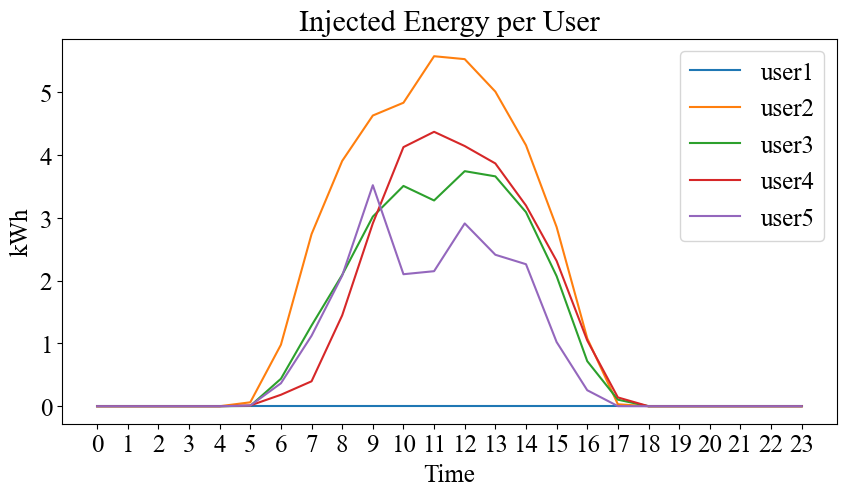

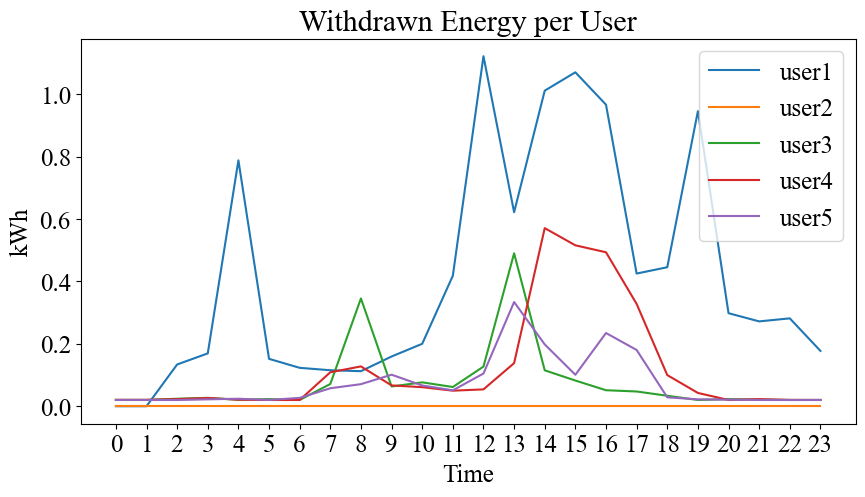

In [6]:
import matplotlib.pyplot as plt

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
# Set font size
plt.rcParams.update({'font.size': 18})

# Initialize lists to store injected and withdrawn energy data for all users
injected_energy_all = []
withdrawn_energy_all = []

# Iterate through each user in the users_data dictionary
for user, data in users_data.items():
    # Extract energy data for the current user
    energy_data = data['energy']
    
    # Extract injected and withdrawn energy from each tuple
    injected = [t[0] for t in energy_data]
    withdrawn = [t[1] for t in energy_data]
    
    # Append the injected and withdrawn energy to the respective lists
    injected_energy_all.append(injected)
    withdrawn_energy_all.append(withdrawn)

# Plot the injected energy for all users
plt.figure(figsize=(10, 5))
for i in range(len(users_data)):
    plt.plot(range(len(energy_data)), injected_energy_all[i], label=list(users_data.keys())[i])

plt.xlabel('Time')
plt.ylabel('kWh')
plt.title('Injected Energy per User')
plt.xticks(range(len(energy_data)))  # Set tick positions to be every element
plt.legend()
plt.show()

# Plot the withdrawn energy for all users
plt.figure(figsize=(10, 5))
for i in range(len(users_data)):
    plt.plot(range(len(energy_data)), withdrawn_energy_all[i], label=list(users_data.keys())[i])

plt.xlabel('Time')
plt.ylabel('kWh')
plt.title('Withdrawn Energy per User')
plt.xticks(range(len(energy_data)))  # Set tick positions to be every element
plt.legend()
plt.show()
